In [1]:
import os
import scipy.sparse as sp_sparse
import scanpy as sc
import numpy as np
from anndata import AnnData
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
sample_info = pd.read_csv('[PATH]/info/HTO_barcode_info.csv')
subject2clinical = {s:c for s, c in zip(sample_info.subject_id, sample_info.clinical)}

In [3]:
tid2tissue = {1: 'PFC',
 2: 'PFC',
 3: 'medulla',
 4: 'medulla',
 5: 'choroidplexus',
 6: 'choroidplexus'}

In [4]:
df_meta = pd.read_csv('../processed_data/clean_data/metadata.csv', index_col = 0)    

df_meta['clinical'] = [subject2clinical[s] for s in df_meta.subject_id]
df_meta.tissue = [t.split('_')[0] for t in df_meta.tissue]
df_meta.tissue = df_meta.tissue.astype('category')
df_meta.subject_id = df_meta.subject_id.astype('category')
df_meta.celltype = df_meta.celltype.astype('category')
df_meta.pid = df_meta.pid.astype('category')

features = ['celltype', 'subject_id', 'pid', 'tissue', 'tissue_id', 'clinical']
df_meta = df_meta[features]

In [5]:
from collections import Counter
Counter(pd.read_csv('../processed_data/clean_data/metadata.csv', index_col = 0).pid)

Counter({'set1-A': 5074,
         'set1-B': 5519,
         'set2-A': 1856,
         'set2-B': 2024,
         'set3-A': 3636,
         'set3-B': 3875,
         'set4-A': 2034,
         'set4-B': 2026,
         'set5-A': 3984,
         'set5-B': 4049,
         'set6-A': 5549,
         'set6-B': 6030,
         'set7-A': 3207,
         'set7-B': 3361,
         'set8-A': 4441,
         'set8-B': 4251,
         'set9-A': 3548,
         'set9-B': 4093})

In [6]:
def get_freq_mat(df_count):
    ## input: df_count, assumed indexed by [(pid, ct)]
    num_ct = len(set([i[-1] for i in df_count.index]))
    
    index_mat = df_count.index.values.reshape(-1, num_ct)

    for i in range(index_mat.shape[0]):
        assert len(set([s[0] for s in index_mat[i, :]])) == 1

    count_mat = df_count.values.reshape((-1, num_ct))
    row_notallzero = (count_mat.sum(axis = 1) > 0)
    count_mat = count_mat[row_notallzero]
    index_mat = index_mat[row_notallzero]
    
    freq_mat = count_mat / count_mat.sum(axis = 1, keepdims = True)
    logfreq_mat = np.log10(freq_mat + 1e-5)      
    return count_mat, freq_mat, logfreq_mat, index_mat

id2pid = sorted(set(df_meta.pid))
pid2subject = {p:s for s, p in zip(df_meta.subject_id, df_meta.pid)}
id2clinical = np.array([subject2clinical[pid2subject[p]] for p in id2pid])

df_count = df_meta.copy()
df_count = df_count.groupby(['pid', 'tissue_id', 'celltype']).count().iloc[:, 0]
df_count = df_count.fillna(0)

count_mat, freq_mat, logfreq_mat, index_mat = get_freq_mat(df_count)

id2ct = np.array([i[-1] for i in index_mat[0, :]])
id2pid = np.array([i[0] for i in index_mat[:, 0]])
id2subject = np.array([pid2subject[p] for p in id2pid])
id2clinical = np.array([subject2clinical[pid2subject[i[0]]] for i in index_mat[:, 0]])
id2tissue_id = np.array([int(i[1]) for i in index_mat[:, 0]])
id2tissue = np.array([tid2tissue[int(i[1])] for i in index_mat[:, 0]])

In [7]:
#freq_mat.ravel(), 

df_plot = pd.DataFrame({'freq': freq_mat.ravel(), 
            'celltype': [i[-1] for i in index_mat.ravel()],
             'clinical': [subject2clinical[pid2subject[i[0]]].split('_')[0] for i in index_mat.ravel()],
             'tissue': [tid2tissue[int(i[1])] for i in index_mat.ravel()]
             })


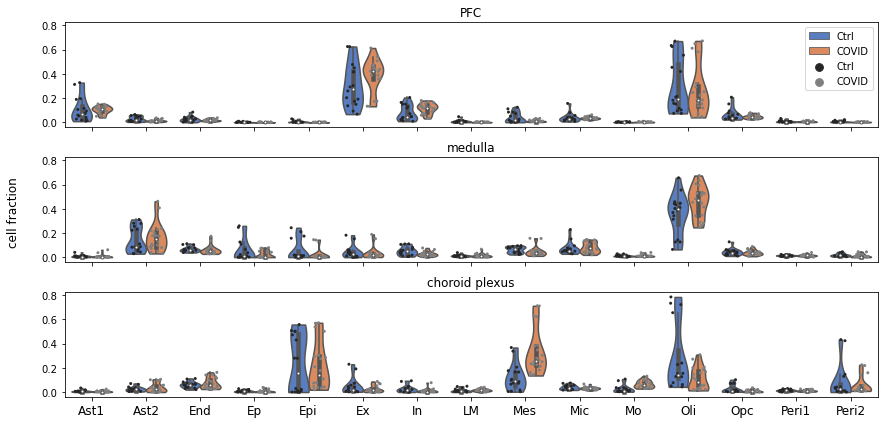

In [8]:
import seaborn as sns

fig, axes = plt.subplots(3, 1, figsize = (12, 6), sharex=True, sharey=True)

for ip, t in enumerate(['PFC', 'medulla', 'choroidplexus']):
    tmp = df_plot[df_plot.tissue == t]
    ax = sns.stripplot(x="celltype", y="freq", size = 3, hue = 'clinical',
                    data=tmp, ax = axes[ip], color = 'gray', jitter=0.25, dodge=True)
    
    ax = sns.violinplot(x="celltype", y="freq", hue="clinical", scale = 'width',
                    data=tmp, palette="muted", ax = axes[ip], cut = 0, width = .75)
    plt.sca(ax)
    if t != 'choroidplexus':
        plt.title(t, fontsize = 12)
    else:
        plt.title('choroid plexus', fontsize = 12)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(fontsize = 12)
    
    if ip != 0:
        ax.get_legend().remove()
    else:
        plt.legend()
    
fig.text(-0.02, 0.5, 'cell fraction', va='center', 
         rotation='vertical', fontsize = 12)
plt.tight_layout()

plt.savefig('../figs/cell_fraction_all_violin.pdf', bbox_inches='tight')
plt.savefig('../figs/png/cell_fraction_all_violin.png', dpi = 600, bbox_inches='tight')

plt.show()